Anomaly detection with LSTM autoencoder

In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [27]:
seed(10)
set_random_seed(10)

In [28]:
data_dir = '2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir,filename),sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

In [29]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_Bearing_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (984, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [30]:
train = merged_data['2004-02-12 10:52:39':'2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print('Training dataset shape:',train.shape)
print('Test dataset shape:',test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


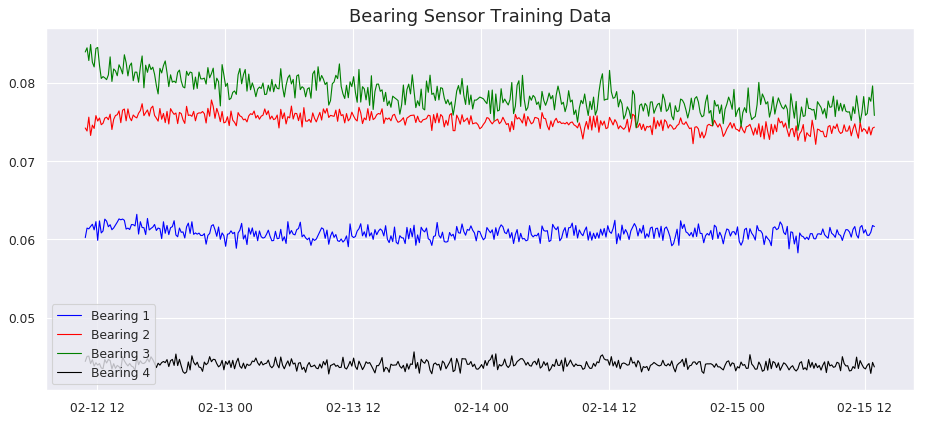

In [31]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(train['Bearing 1'],label='Bearing 1',color='blue',animated=True,linewidth=1)
ax.plot(train['Bearing 2'],label='Bearing 2',color='red',animated=True,linewidth=1)
ax.plot(train['Bearing 3'],label='Bearing 3',color='green',animated=True,linewidth=1)
ax.plot(train['Bearing 4'],label='Bearing 4',color='black',animated=True,linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

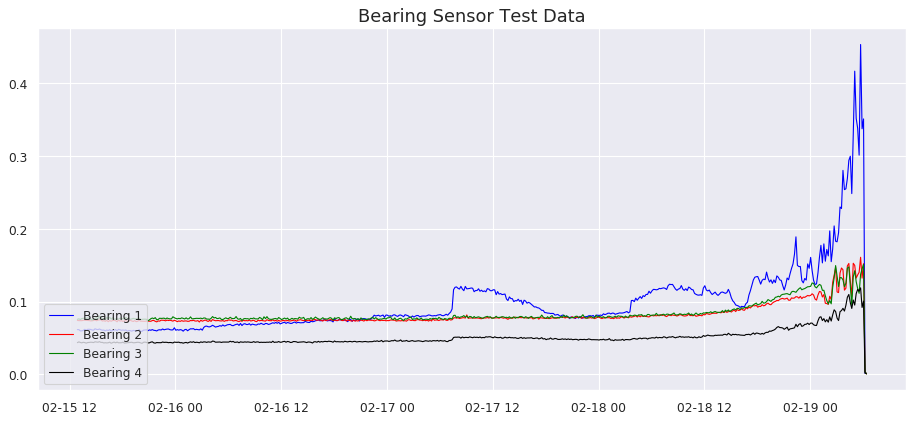

In [32]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(test['Bearing 1'],label='Bearing 1',color='blue',animated=True,linewidth=1)
ax.plot(test['Bearing 2'],label='Bearing 2',color='red',animated=True,linewidth=1)
ax.plot(test['Bearing 3'],label='Bearing 3',color='green',animated=True,linewidth=1)
ax.plot(test['Bearing 4'],label='Bearing 4',color='black',animated=True,linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Data', fontsize=16)
plt.show()

In [33]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

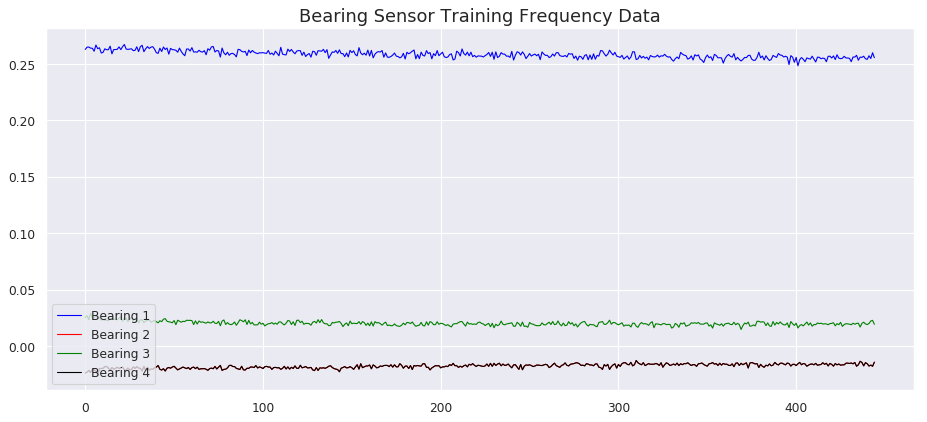

In [34]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(train_fft[:,0].real,label='Bearing 1',color='blue',animated=True,linewidth=1)
ax.plot(train_fft[:,1].real,label='Bearing 2',color='red',animated=True,linewidth=1)
ax.plot(train_fft[:,2].real,label='Bearing 3',color='green',animated=True,linewidth=1)
ax.plot(train_fft[:,3].real,label='Bearing 4',color='black',animated=True,linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

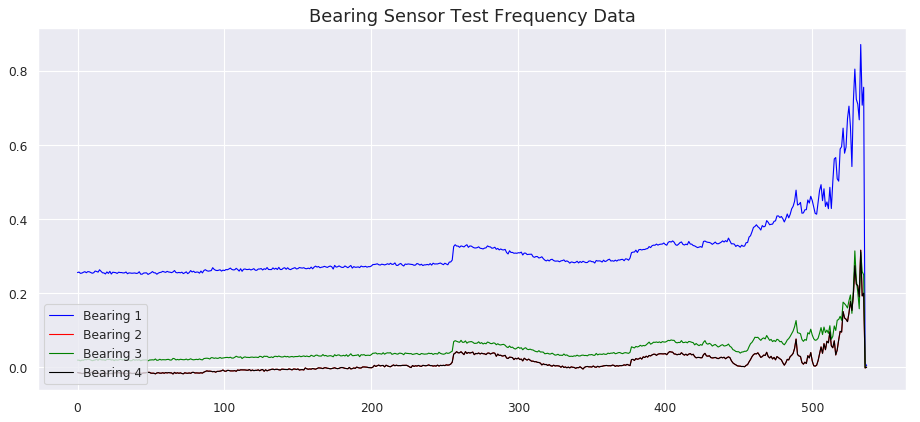

In [35]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(test_fft[:,0].real,label='Bearing 1',color='blue',animated=True,linewidth=1)
ax.plot(test_fft[:,1].real,label='Bearing 2',color='red',animated=True,linewidth=1)
ax.plot(test_fft[:,2].real,label='Bearing 3',color='green',animated=True,linewidth=1)
ax.plot(test_fft[:,3].real,label='Bearing 4',color='black',animated=True,linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [36]:
train.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [37]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = 'scaler_data'
joblib.dump(scaler,scaler_filename)

['scaler_data']

In [38]:
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
print("Training data shape:",X_train.shape)
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
print("Test data shape:",X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [39]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1],X.shape[2]))
    L1 = LSTM(16,activation='relu',return_sequences=True,
             kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs,outputs=output)
    
    return model

In [40]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam',loss='mae')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_16 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 4)              68  

In [41]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                   validation_split=0.05).history

Train on 422 samples, validate on 23 samples
Epoch 1/100
422/422 [==============================] - 2s 4ms/step - loss: 0.4472 - val_loss: 0.3244
Epoch 2/100
422/422 [==============================] - 0s 373us/step - loss: 0.3899 - val_loss: 0.2580
Epoch 3/100
422/422 [==============================] - 0s 382us/step - loss: 0.3121 - val_loss: 0.1797
Epoch 4/100
422/422 [==============================] - 0s 396us/step - loss: 0.2059 - val_loss: 0.1589
Epoch 5/100
422/422 [==============================] - 0s 403us/step - loss: 0.1274 - val_loss: 0.1406
Epoch 6/100
422/422 [==============================] - 0s 407us/step - loss: 0.1084 - val_loss: 0.1232
Epoch 7/100
422/422 [==============================] - 0s 406us/step - loss: 0.1040 - val_loss: 0.1190
Epoch 8/100
422/422 [==============================] - 0s 403us/step - loss: 0.1027 - val_loss: 0.1152
Epoch 9/100
422/422 [==============================] - 0s 400us/step - loss: 0.1020 - val_loss: 0.1145
Epoch 10/100
422/422 [========

422/422 [==============================] - 0s 372us/step - loss: 0.0939 - val_loss: 0.0943
Epoch 80/100
422/422 [==============================] - 0s 366us/step - loss: 0.0939 - val_loss: 0.0924
Epoch 81/100
422/422 [==============================] - 0s 369us/step - loss: 0.0938 - val_loss: 0.0945
Epoch 82/100
422/422 [==============================] - 0s 366us/step - loss: 0.0938 - val_loss: 0.0938
Epoch 83/100
422/422 [==============================] - 0s 365us/step - loss: 0.0941 - val_loss: 0.0930
Epoch 84/100
422/422 [==============================] - 0s 371us/step - loss: 0.0943 - val_loss: 0.0939
Epoch 85/100
422/422 [==============================] - 0s 369us/step - loss: 0.0938 - val_loss: 0.0939
Epoch 86/100
422/422 [==============================] - 0s 371us/step - loss: 0.0940 - val_loss: 0.0930
Epoch 87/100
422/422 [==============================] - 0s 368us/step - loss: 0.0937 - val_loss: 0.0944
Epoch 88/100
422/422 [==============================] - 0s 365us/step - loss:

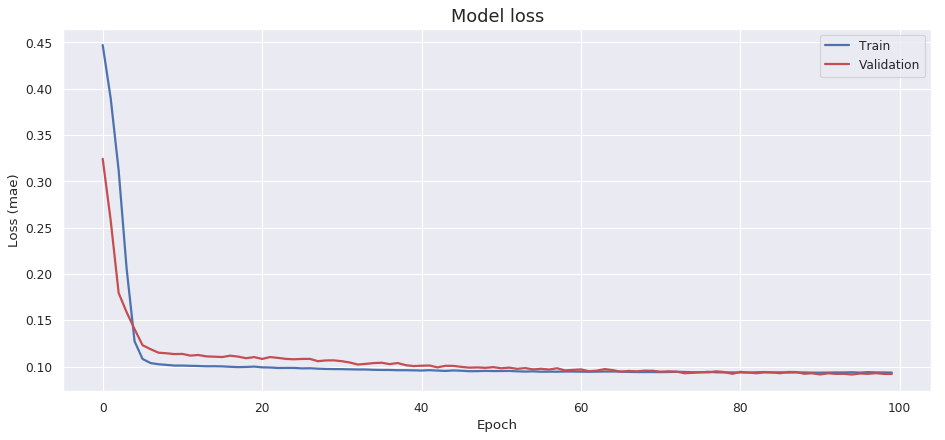

In [42]:
fig, ax = plt.subplots(figsize=(14,6),dpi=80)
ax.plot(history['loss'],'b',label='Train',linewidth=2)
ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

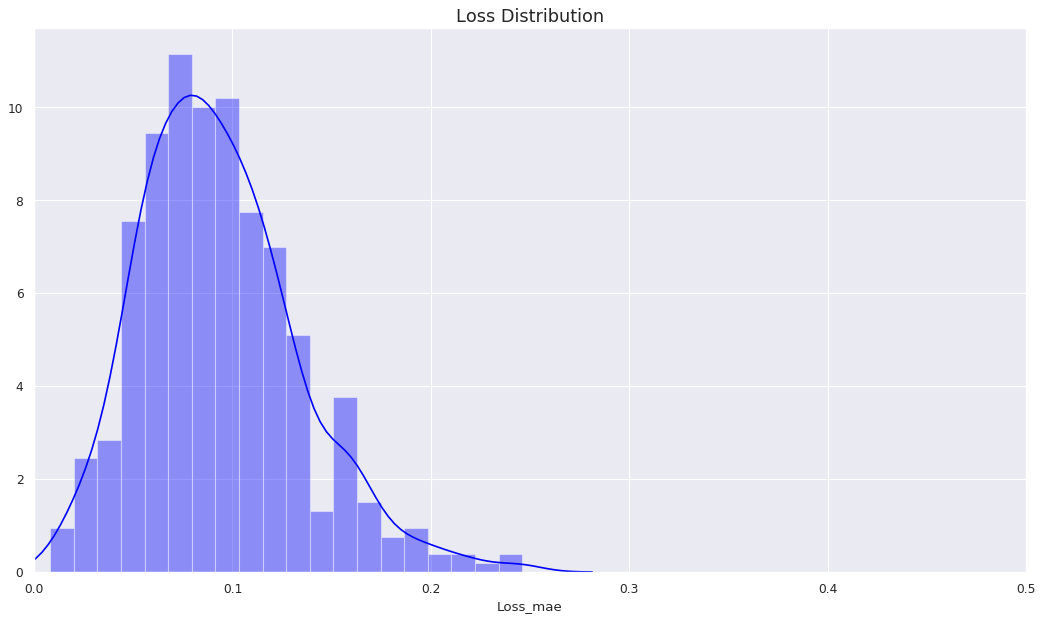

In [43]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0],X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain),axis=1)
plt.figure(figsize=(16,9),dpi=80)
plt.title('Loss Distribution',fontsize=16)
sns.distplot(scored['Loss_mae'],bins=20,kde=True,color='blue')
plt.xlim([0.0,0.5])

In [44]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0],X_pred.shape[2])
X_pred = pd.DataFrame(X_pred,columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0],X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest),axis=1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.094287,0.275,False
2004-02-15 13:02:39,0.171426,0.275,False
2004-02-15 13:12:39,0.066431,0.275,False
2004-02-15 13:22:39,0.054365,0.275,False
2004-02-15 13:32:39,0.037563,0.275,False


In [45]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0],X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train,columns=test.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain),axis=1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

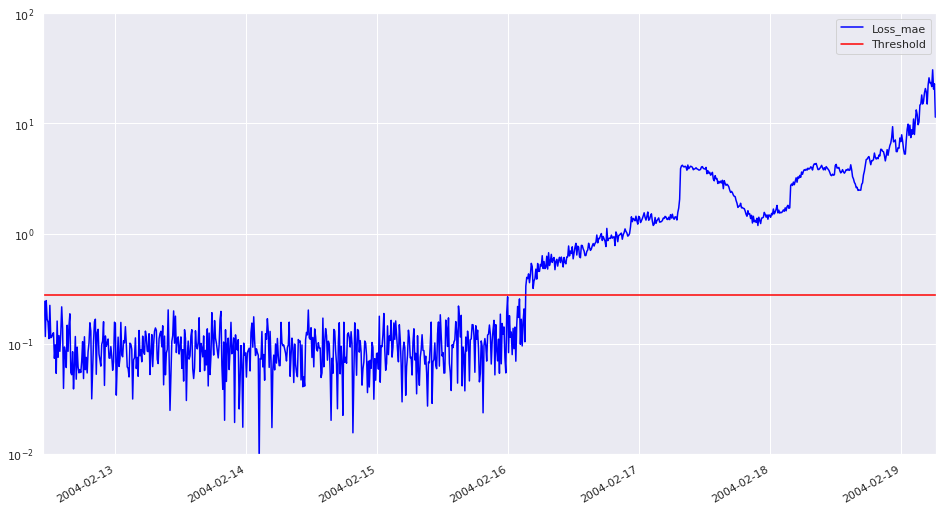

In [48]:
scored.plot(logy=True, figsize=(16,9), ylim=[1e-2,1e2],color=['blue','red'])